In [1]:
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree

import tensorflow as tf
import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)

%config Completer.use_jedi = False

In [229]:
#load distance maps and endpoints dataset
def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
    rr = np.load(dm_file, allow_pickle=True)
    X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
    return X_train[y_train==name][:,:-4]

dm_file = 'data/Fits_4H_dm_phi.npz'
rr = np.load(dm_file, allow_pickle=True)
X_train, y_train , featNames = [rr[f] for f in rr.files]
# = 'data/4H_dataset/models/'
# cmd.load(f'{model_direc}{y_train[0]}.pdb')
# cmd.save(f'output/test.pdb')

#endpoints for data set 
Fits4H_file = 'data/Fits_4H.csv'
dfRead = pd.read_csv(Fits4H_file)
df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
df2 = ft.EndPoint(df1)
ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
X = ep


In [282]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return ep_in[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint

def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    #single batch code  util.npose_util as xform_npose
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)

def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization. needs additional translation/reflection"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform


def rotate_base_tri_Zplane(endpoint_midpoints, target_point=4, index_mobile=[1,2,3]):
    """rotate points into the z-plane for trilaterization. Target point ensures that point is positive in Z"""
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #based on target point guaranteed to be positive
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    return rot[...,:3] #remove npose rotate dimension

In [283]:
#prep endpoint dataset for use with easy use with Trilateration:
#Essentially identify 3 points on 1st two helices (Rotate/Translate to Z-plane) with 
#index mobile 1 at 0,0,0, target point in the positive z (trilateration assumtion)
#roughly 10% of z values of helices 3/4 are in the negative feild, with point enforced 4 positive

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 
dist = dist.reshape((dist.shape[0],-1))

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 
dist_mp = dist_mp.reshape((dist_mp.shape[0],-1))


zp_ep_mp = rotate_base_tri_Zplane(ep_mp,  target_point=4, index_mobile=[1,2,3])

In [233]:
zp_ep_mp[0,9]

array([ 6.5 , 12.48,  5.82])

In [13]:
#methods to index needed indices from generator

def helix_dindex(helices_to_keep, num_helices=4, intraHelixDist=True):
    """Get index values for parts of the distance map"""
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    helix_used = np.array(helices_to_keep,dtype=int)
    
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    tot_ind = []
    
    if intraHelixDist:
        #get indices of distance map that correspond to each helix, overlap is distances between specified endpoints
        for x in helix_used:
            new_ind = np.intersect1d(mat_ind[h_ep[x]], mat_ind.T[h_ep[x]])
            tot_ind.extend(new_ind)
    
    
    for x in permutations(helix_used,2):
        new_ind = np.intersect1d(mat_ind[h_ep[x[0]]], mat_ind.T[h_ep[x[1]]])
        tot_ind.extend(new_ind)
    
    #convert to generator indices (indices of iu1 array)
    out_ind = []
    for x in tot_ind:
        if len(np.nonzero(mat_ind[iu1]==x)[0])>0:
            out_ind.append(np.nonzero(mat_ind[iu1]==x))

    return np.sort(np.array(out_ind).flatten())


def point_dindex(target_points, ref=[4], num_helices = 4):
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    dindex = []
    
    for tp in target_points:
        for ref_ind in ref:
            dindex.append(mat_ind[ref_ind,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((len(target_points),-1))

def target_dindex(target_points, oneRef = True, num_helices = 5, baseTri_out=True):
    """Distance map indices for base triangle and output distance map"""
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)

    if oneRef:
        ref = [1,2,3]
        base_tri = [mat_ind[1][2],mat_ind[2][3],mat_ind[1][3]] #p1 to p2, p2 to p3, p1 to p3
        
    else:
        ref = [0,1,2]
        base_tri = [mat_ind[0][1],mat_ind[1][2],mat_ind[0][3]] #p0 to p1, p1 to p2, p0 to p3
    
    dindex = []
    
    for tp in target_points:
        dindex.append(mat_ind[ref,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((-1,len(base_tri))),base_tri

def minMax_indices(distance_index, point_index, minmax_obj):
    
    #assemble conversions 
    #converts output from generator back to real distances
    dMin_all = tf.convert_to_tensor(minmax_obj.data_min_, dtype=tf.float32)
    mScale_all = tf.convert_to_tensor(minmax_obj.scale_, dtype = tf.float32)
    mMin = tf.convert_to_tensor(minmax_obj.feature_range[0], dtype = tf.float32)

    #index just the distances we need for calculation
    dMin = tf.gather(dMin_all, distance_index,axis=0)
    mScale = tf.gather(mScale_all, distance_index,axis=0)

    #indexes we need to determine the +/- z value of the new points
    pindex = point_dindex([5,6,7], ref=[4], num_helices = 4)
    dMin_nwp = tf.gather(dMin_all, point_index,axis=0)
    mScale_nwp = tf.gather(mScale_all, point_index,axis=0)
    
    return dMin, mScale, mMin, dMin_nwp,  mScale_nwp 

def ref_distmap_index(distances, num_helices = 4):
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    iu1_flat = iu1[0]*8+iu1[1]
    
#     testDist1 = brec.mm.transform(testDist)

#     g1 = tf.convert_to_tensor(testDist1[:batch],dtype=tf.float32)
    
    return distances[np.ix_(range(distances.shape[0]),iu1_flat)]

def convert_dMat_to_iu1_index(indices_in, num_helices = 4):
    """Converts indices on flattened distance index to iu1 single indices"""
    
    
    conv_array = np.array(indices_in).flatten()
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    #convert to generator indices (indices of iu1 array)
    out_ind = []
    for x in conv_array:
        if len(np.nonzero(mat_ind[iu1]==x)[0])>0:
            out_ind.append(np.nonzero(mat_ind[iu1]==x))
            
    out_ind = np.array(out_ind)
        
    return out_ind.reshape(conv_array.shape)

In [14]:
def prep_base_triangle_trilateriation(dindex, base_tri, distance_map):
    """Return x,y,z coords on z-plane of base triangle of tetrahedron from a distance map."""
    
#     dindex, base_tri = target_dindex(targ_dind, oneRef = oneRef, num_helices = num_helices)
# #     print(dindex)
# #     print(base_tri)
    
    #test case input data: prep base triangles for trilateration at zplane, (0,0,0) (dvar,0,0) (ivar,jvar,0)
    desired_dm = distance_map[:, base_tri] #base tri from dindex

    dvar_index = tf.convert_to_tensor(0 ,dtype=tf.int32)
    s2_index = tf.convert_to_tensor(2 ,dtype=tf.int32) # we would like the angle across from side 2
    s3_index = tf.convert_to_tensor(1 ,dtype=tf.int32)

    #x value representing center of 2nd sphere at (dvar,0,0) aka s1
    dvar = tf.reshape(tf.gather(desired_dm, dvar_index,axis=1),(-1,1)) #side 1
    s2 = tf.reshape(tf.gather(desired_dm,   s2_index,axis=1),(-1,1))
    s3 = tf.reshape(tf.gather(desired_dm,   s3_index,axis=1),(-1,1))

    #calculate the opposite angle of the the third side of base triangle using law of cosines
    s1sq = tf.square(dvar)
    s2sq = tf.square(s2)
    s3sq = tf.square(s3)
    ang3 = np.arccos((-s3sq+s2sq+s1sq)/(2*dvar*s2))

    #take third point of base triangle via distance * vector
    v13 = tf.concat([tf.cos(ang3), tf.sin(ang3), tf.zeros_like(ang3)], axis=1)
    p3 = s2*v13
    #center points of 3rd sphere
    ivar = tf.reshape(p3[:,0],(-1,1))
    jvar = tf.reshape(p3[:,1],(-1,1))


    #convert all to float32 to match generator output
    #expand to dindex size 

    dvar = tf.cast(tf.repeat(dvar,dindex.shape[0],axis=1),dtype=tf.float32)
    ivar = tf.cast(tf.repeat(ivar,dindex.shape[0],axis=1),dtype=tf.float32)
    jvar = tf.cast(tf.repeat(jvar,dindex.shape[0],axis=1),dtype=tf.float32)
    
    return dvar, ivar, jvar


In [78]:
#tensor flow loss function to guide backprop


@tf.function
def maskLoss(y_actual, y_pred,mask):
    """Loss Function for mantaing shape of input helices"""
    custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
    return custom_loss_val

@tf.function
def midpoints_loss(g1, target, mmTuple, baseTuple, dindex, pindex, batch_size):
    """Loss function to move output of two generated helices to target midpoint"""
    
    
    #now using dindex gather the desired indices for tetrahedron calcs

    #radius of the spheres, aka the distances to unmasked endpoints
    g2 = tf.gather(g1,dindex,axis=1)
    
    dvar, ivar, jvar = baseTuple 
    dMin, mScale, mMin, dMin_nwp,  mScale_nwp = mmTuple
    

    #see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
    #inspect .scale_
    conv_dist = tf.add(tf.divide(tf.subtract(g2, mMin), mScale),dMin)
    #transpose lets you easily grab all distances with gather/axis 
    conv_dist_squared = tf.transpose(tf.square(conv_dist),perm=[0, 2, 1]) 

    r1_sq = tf.gather(conv_dist_squared, 0, axis=1) 
    r2_sq =  tf.gather(conv_dist_squared,1, axis=1) 
    r3_sq = tf.gather(conv_dist_squared, 2, axis=1)

    #calculate coordinates of spherial intersect
    x = tf.divide(tf.add(tf.subtract(r1_sq,r2_sq),tf.square(dvar)),tf.multiply(2.0,dvar))
    y1 = tf.divide(tf.add(tf.add(tf.subtract(r1_sq,r3_sq), tf.square(ivar)), tf.square(jvar)),tf.multiply(2.0,jvar))
    y = tf.subtract(y1,tf.multiply(tf.divide(ivar,jvar),x))
    
    pre_z = tf.subtract(tf.subtract(r1_sq,tf.square(x)),tf.square(y))
    fixed_z = tf.clip_by_value(pre_z, 1e-10, 100)
    
    #adds  to negative values to 0 for sqrt,
    #I think is okay as zero z will imply lengthening of distances to match a non-zero target midpoint,
    #pushing the network in the desired direction?
    
    z = tf.sqrt(fixed_z) #assume positive solution
    z_neg = tf.multiply(z,-1) #assume negative soluation

    #new points, with both assumptions
    nwp = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z,(batch_size,-1,1))), axis=2)  #

    nwp_negz = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                    tf.reshape(y,(batch_size,-1,1)),
                    tf.reshape(z_neg,(batch_size,-1,1))), axis=2)  #
    
    #some positive solutions assumptions,
    # assume first [i4] is actual positive use remaining distances of i4 to (i5,i6,i7) to determine z sign
    # closest to matching distance is used


    #let's start by calculating all i4 to (i5,i6,i7) distances

    #stop the gradients since these are used to index gather and scatter
    #unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
    nwp_p =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp,axis=2))
    nwp_n =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp_negz,axis=2))
    
    nwp_dist_pz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_p), 3)),(-1,4,4)) #distance calc +1e6?
    nwp_dist_nz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_n), 3)),(-1,4,4))  #distance calc
        
    z_pn_dist_pre_con = tf.gather(g1,pindex,axis=1)
    z_pn_dist = tf.add(tf.divide(tf.subtract(z_pn_dist_pre_con, mMin), mScale_nwp),dMin_nwp)
    
    #index p4 to p5,p6,p7
    #rewrite as non-slice version of this
    
    nwp_dist_pz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_pz, [0], axis=1), [1,2,3], axis=2))
    nwp_dist_nz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_nz, [0], axis=1), [1,2,3], axis=2))
      
    nwp_dist_pz_c = tf.expand_dims(nwp_dist_pz_c,axis=2)
    nwp_dist_nz_c = tf.expand_dims(nwp_dist_nz_c,axis=2)

#     #using a single distance decide the z assumption and apply
    correct_z_assum = tf.abs(z_pn_dist - nwp_dist_nz_c) < tf.abs(z_pn_dist - nwp_dist_pz_c)
    d = tf.add(tf.multiply(tf.cast(correct_z_assum,tf.float32),-2),1)
    e = tf.repeat(tf.ones_like(d),2,axis=2)
    f = tf.ones((batch_size,1,3),dtype=tf.float32)
    g = tf.concat((f,tf.concat((e,d),axis=2)),axis=1) #add the rest of the residues as ones
    nwp_final = tf.multiply(g,nwp)
    
    midpoint = tf.reduce_mean(nwp_final,axis=1)
    return tf.square(tf.subtract(midpoint,target)) # means squared loss to desired midpoint

In [338]:
def buttress_via_midpoint(gen_obj, ref_map, target_mp, batch_size=32,cycles=100, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=5.0, z_size=12):
    
    batch_indices = np.repeat(np.array(range(ref_map.shape[0])),batch_size)
    batch = batch_indices.shape[0]
    ref_map = np.repeat(ref_map, batch_size, axis=0)
    
    #input to generator (determinstic output)
    if input_z is None:
        input_z = tf.random.uniform(shape=(batch, z_size), minval=-1, maxval=1)
        
    input_z_var = tf.Variable(input_z)
    
    #establish indices for distances to reference
    #prep base triangle, convert distances from minmax to regular
    dindex, base_tri = target_dindex(target_ep, oneRef = True, num_helices = num_helices)
    base_tri = convert_dMat_to_iu1_index(base_tri) #dirty
    pindex = point_dindex(target_ep[1:], ref=[target_ep[0]], num_helices = num_helices)

    #convert generator output to 'real distances'
    #dMin, mScale, mMin, dMin_nwp,  mScale_nwp = minMax_indices(dindex, pindex, brec.mm)
    mmTuple = minMax_indices(dindex, pindex, gen_obj.mm)

    # prepare base triangle for trilateriation (z plane , p1 at origin, p2 positive x)
    #dvar, ivar, jvar = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)
    #baseTuple = prep_base_triangle_trilateriation(dist[:batch], targ_dind = target_ep, oneRef = True, num_helices=num_helices)

    baseTuple = prep_base_triangle_trilateriation(dindex, base_tri, ref_map)
    
    dvar,ivar,jvar = baseTuple
    
    if tf.reduce_sum(dvar)<0:
        print('dvar',dvar)
    if tf.reduce_sum(ivar)<0:
        print('ivar',ivar)
    if tf.reduce_sum(jvar)<0:
        print('jvar',jvar)
    
    
    #mask for keeping buttress helices in same orientation
    h_index = helix_dindex([0,1], num_helices=4, intraHelixDist=True)
    helix_keep_mask = np.zeros((ref_map.shape[1],),dtype=np.int32)
    helix_keep_mask[h_index] = 1
    helix_keep_mask = tf.convert_to_tensor(helix_keep_mask,dtype=tf.float32)
    
    #store grads and inputs as we backpropagate
    z=[]
    loss_mask = []
    loss_mp = []
    grads = []

    scale = tf.constant(scale)
    ref_map_conv = gen_obj.mm.transform(ref_map)
    ref_map_conv = tf.convert_to_tensor(ref_map_conv,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=rate)

    g_o = gen_obj.g(input_z_var)
    masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
    mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch), scale)
    loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

    print('start_masked',np.round(np.sum(masked_loss),2))
    print('start_mp',np.round(np.sum(mp_loss),2))


    for t in range(1,cycles):

        #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = gen_obj.g(input_z_var)
            masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
            mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch),scale)

            loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

        g_grads = g_tape.gradient(loss, input_z_var)

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))
        
        z.append(tf.identity(input_z_var).numpy())
        loss_mask.append(tf.identity(masked_loss).numpy())
        loss_mp.append(tf.identity(mp_loss).numpy())

    print('end_masked', np.round(np.sum(masked_loss),2))
    print('end_mp', np.round(np.sum(mp_loss),2))
    
    return z, loss_mask, loss_mp, batch_indices
    
    

In [235]:
np.round(zp_ep_mp[0],2)

array([[ 9.35, 12.37, -5.96],
       [ 0.  , -0.  , -0.  ],
       [10.4 ,  0.  ,  0.  ],
       [23.18, 23.99,  0.  ],
       [14.48, 22.47,  4.66],
       [ 6.26,  0.85, 11.63],
       [ 0.1 ,  5.49,  7.34],
       [ 5.17, 21.1 , -0.35],
       [10.73,  9.09, -1.49],
       [ 6.5 , 12.48,  5.82]])

In [314]:

gen="data/BestGenerator"
gen_obj = ge.BatchRecon(gen)
output1=gen_obj.generate(z=12,batch_size=12) #example generator

target_midpoint = tf.convert_to_tensor([5.0,10.0,5.0])

In [315]:
#will need to add method to convert helix 1,2,3,4 to just helix 1,2 (remove 1,2 convert 3,4 to )
ref_map_base = ref_distmap_index(dist, num_helices=4)

In [316]:
output_z = buttress_via_mask_only(gen_obj, ref_map_base[:10], target_midpoint, batch_size=64,cycles=200, input_z=None, 
                          rate=0.01, target_ep=[4,5,6,7], num_helices=4, oneRef=False,
                          scale=100.0)

start_masked 512.73
start_mp 696.4
end_masked 12.54
end_mp 557.57


In [340]:
#gen_obj  generator network to propagate through
#ref_map_base   distance map to buttress from
#target in space (after z-orientation)
#oneRef - False -> use first three endpoints of two helices to buttress [0,1,2], True = use [1,2,3]
#scale how much to divide midpoints loss by to miss with mask loss since it is no longer normalized to min max of generator
#batch, (one batch per eacy reference distance map (ref_map_base))


output_z, loss_mask, loss_mp, batchInd = buttress_via_midpoint(gen_obj, ref_map_base[:20], target_midpoint, batch_size=32,cycles=200, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=200.0)

start_masked 523.3
start_mp 272.62
end_masked 12.24
end_mp 21.81


In [324]:
np.sum(np.sum(loss_mp[-1],axis=1)<0.001)


74

In [325]:
len(np.sum(loss_mp[-1],axis=1))

640

In [326]:
# np.sum(loss_mask[-1]<0.001,axis=1)>27

In [327]:
best_mp = np.sum(loss_mp[-1]<0.001,axis=1)>2

In [328]:
zuse = output_z[-1][best_mp]
zuse.shape

(91, 12)

In [341]:
uInd = batchInd[best_mp]

In [342]:
uInd

array([ 2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
        4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 14, 15, 15, 15, 15, 15, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 18, 18, 18, 19])

In [317]:
zuse = output_z[-1]

In [329]:
gen_obj.generate(z=12,input_z=zuse,batch_size=zuse.shape[0])
gen_obj.MDS_reconstruct_()
gen_obj.reconstructionError()
npo = gen_obj.to_npose()


In [330]:
out_ep = np.array(gen_obj.reconsMDS_)

In [331]:
#check and see real midpoints shift relative to proper reference



# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)


                                                                    #oneRef indices
out_zp_ep = rotate_base_tri_Zplane(out_ep,  target_point=4, index_mobile=[1,2,3])


out_mp_01 = get_midpoint(out_zp_ep,helices_desired=[0,1],num_helices=4)
out_mp_23 = get_midpoint(out_zp_ep,helices_desired=[2,3],num_helices=4)


#mp distance map
out_ep_mp = np.hstack((out_zp_ep.reshape((-1,24)), out_mp_01, out_mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9




In [332]:
tomp = np.sqrt(np.sum(np.square(out_ep_mp[:,9]-target_midpoint),axis=1))

In [334]:
np.mean(tomp)

2.6555066

In [119]:
outDirec= 'output/'
for i,c in enumerate(gen_obj.npose_list):
    nu.dump_npdb(c,f'{outDirec}build{i}.pdb')

In [ ]:
#best fit 

In [485]:
#moving 2 onto on

#new endpoints #sel2
out_zp_ep_4 = out_zp_ep[:,:4,:]

#old endpoints #sel1
original_ep = zp_ep_mp[uInd,:4,:] #remove 2 midpoints and 4 top points

In [499]:
#Kabsch
#
#Thanks to below for this code modified to batch form 
#https://pymolwiki.org/index.php/Kabsch

# check for consistency
assert len(out_zp_ep_4) == len(original_ep)
L = len(out_zp_ep_4)
assert L > 0
#centering to prevent affine transformaiton
#these are centered at zero on the z-plane already
E0 = np.sum( np.sum(np.square(out_zp_ep_4),axis=1),axis=1) + np.sum( np.sum(np.square(original_ep),axis=1),axis=1)

# This beautiful step provides the answer.  V and Wt are the orthonormal
# bases that when multiplied by each other give us the rotation matrix, U.
# S, (Sigma, from SVD) provides us with the error!  Isn't SVD great!

#2 onto #1
                                                       #2                      #1
V, S, Wt = np.linalg.svd( np.matmul(np.transpose(out_zp_ep_4,axes=[0,2,1]), original_ep))

# we already have our solution, in the results from SVD.
# we just need to check for reflections and then produce
# the rotation.  V and Wt are orthonormal, so their det's
# are +/-1.

reflect = np.linalg.det(V) * np.linalg.det(Wt)
proper_reflection = ((reflect>0).astype(np.int32)*-2+1) #multiples by 1 or -1 depending if relfect is negative (reflection)

S[:,-1] = S[:,-1]*proper_reflection
V[:,:,-1] = -V[:,:,-1]*proper_reflection.reshape((-1,1))

RMSD = E0 - (2.0 * np.sum(S,axis=1))
RMSD = np.sqrt(np.abs(RMSD / L))

U = np.matmul(V, Wt)
final_ep = np.matmul(out_zp_ep_4, U) 

In [500]:
final_ep_full = np.matmul(out_zp_ep, U) 

In [501]:
#save these comparisons for figure at some point

#method to view points in pymol  
hf.HelicalProtein.makePointPDB(list(final_ep[0]),f'final.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(list(original_ep[0]),f'buttend.pdb',outDirec='output/')    

1

In [502]:
hf.HelicalProtein.makePointPDB(list(out_zp_ep[0]),f'final_pre_full.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(list(out_zp_ep_4[0]),f'final_pre.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(list(final_ep_full[0]),f'final_full.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(list(zp_ep_mp[uInd,:8,:][0]),f'original_full.pdb',outDirec='output/')

1

In [123]:
import Buttress as but

In [128]:
refName = y_train[0]

In [129]:
ref = f'data/4H_dataset/models/{refName}'
pDirec = 'output/'
but.align_helices(ref,pDirec,helix_list=[1,2])

 PyMOL not running, entering library mode (experimental)


<AxesSubplot:ylabel='Count'>

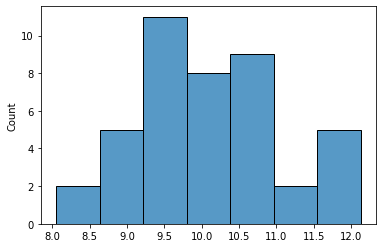

In [227]:
mp_01 = get_midpoint(out_ep,helices_desired=[0,1])
mp_02 = get_midpoint(out_ep,helices_desired=[2,3])
d= np.linalg.norm(mp_02-mp_01,axis=1)
sns.histplot(d)

In [228]:
mp_02-mp_01

array([[ -2.85,   8.55,  -1.27],
       [  8.88,   0.21,   1.58],
       [ -5.05,   4.57,   7.69],
       [  3.24,  -1.97, -10.27],
       [  2.75,  -7.65,   4.87],
       [ -2.39, -10.91,   3.64],
       [  4.59,  -5.28,  -3.98],
       [ -1.6 ,   8.35,  -3.97],
       [ -6.58,   6.26,   5.09],
       [  3.25,   5.4 ,  -6.05],
       [  5.5 ,  -5.48,  -6.96],
       [ -3.  ,   4.92,  -9.09],
       [  6.23,   6.7 ,  -3.78],
       [ -6.  ,  -7.53,   6.84],
       [ -5.22,   8.36,  -2.46],
       [  9.11,   1.64,  -3.8 ],
       [ -1.33,   4.8 ,  -8.36],
       [  5.86,  -6.48,  -4.36],
       [  9.62,   1.42,  -3.11],
       [  9.31,   1.38,  -5.46],
       [ -1.78,   6.66,  -7.73],
       [ -2.63,   4.26,  -7.45],
       [ -5.22,   7.68,   3.61],
       [ -4.78,   6.73,  -4.8 ],
       [ -2.3 ,  -2.91,   9.94],
       [ -3.54,   9.3 ,  -4.18],
       [ -0.42,   3.87, -10.  ],
       [  5.56,  -2.13,  -7.37],
       [  0.56,   5.47,  -9.51],
       [ -4.27,  11.01,   2.76],
       [  

In [ ]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(list(ep_mp[0][1:5]),f'ep_midpoint.pdb',outDirec='output/')
#hf.HelicalProtein.makePointPDB(dist_mp ,f'buttend.pdb',outDirec='output/')    

In [72]:
def buttress_via_mask_only(gen_obj, ref_map, target_mp, batch_size=32,cycles=100, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=5.0, z_size=12):
    
    
    batch = batch_size*ref_map.shape[0]
    ref_map = np.repeat(ref_map, batch_size, axis=0)
    
    #input to generator (determinstic output)
    if input_z is None:
        input_z = tf.random.uniform(shape=(batch, z_size), minval=-1, maxval=1)
        
    input_z_var = tf.Variable(input_z)
    
    #establish indices for distances to reference
    #prep base triangle, convert distances from minmax to regular
    dindex, base_tri = target_dindex(target_ep, oneRef = True, num_helices = num_helices)
    base_tri = convert_dMat_to_iu1_index(base_tri) #dirty
    pindex = point_dindex(target_ep[1:], ref=[target_ep[0]], num_helices = num_helices)

    #convert generator output to 'real distances'
    #dMin, mScale, mMin, dMin_nwp,  mScale_nwp = minMax_indices(dindex, pindex, brec.mm)
    mmTuple = minMax_indices(dindex, pindex, gen_obj.mm)

    # prepare base triangle for trilateriation (z plane , p1 at origin, p2 positive x)
    #dvar, ivar, jvar = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)
    #baseTuple = prep_base_triangle_trilateriation(dist[:batch], targ_dind = target_ep, oneRef = True, num_helices=num_helices)

    baseTuple = prep_base_triangle_trilateriation(dindex, base_tri, ref_map)
    
    
    #mask for keeping buttress helices in same orientation
    h_index = helix_dindex([0,1], num_helices=4, intraHelixDist=True)
    helix_keep_mask = np.zeros((ref_map.shape[1],),dtype=np.int32)
    helix_keep_mask[h_index] = 1
    helix_keep_mask = tf.convert_to_tensor(helix_keep_mask,dtype=tf.float32)
    
    #store grads and inputs as we backpropagate
    z=[]
    grads = []

    scale = tf.constant(scale)
    ref_map_conv = gen_obj.mm.transform(ref_map)
    ref_map_conv = tf.convert_to_tensor(ref_map_conv,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=rate)

    g_o = gen_obj.g(input_z_var)
    masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
    mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch), scale)
    loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

    print('start_masked',np.round(np.sum(masked_loss),2))
    print('start_mp',np.round(np.sum(mp_loss),2))


    for t in range(1,cycles):

        #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = gen_obj.g(input_z_var)
            masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
            mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch),scale)

#             loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

        g_grads = g_tape.gradient(masked_loss, input_z_var)

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))
        
        z.append(tf.identity(input_z_var))

    print('end_masked', np.round(np.sum(masked_loss),2))
    print('end_mp', np.round(np.sum(mp_loss),2))
    
    return z